<a href="https://colab.research.google.com/github/mayankgrwl97/deep-unsupervised-learning-berkeley/blob/master/demos/lecture2/02_simple_autoregressive_model_on_2d_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

**Visualization Utilities**

In [2]:
def convert_idx_list_to_dist(data, d):
    # data -> [(x1,y1), (x2,y2), (x3,y3), ....] | xi -> [0,d-1], yi -> [0,d-1]
    idxs = data.astype('int32')
    dist = np.zeros((d, d))
    for idx in idxs:
        dist[idx[0], idx[1]] += 1
    dist /= dist.sum() # Probability density function for selecting a particular index 
    return dist

def plot_2d_dist(dist, title='Learned Distribution'):
    plt.figure()
    plt.imshow(dist)
    # plt.axis('off')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x0')
    plt.colorbar()
    plt.show()

def plot_train_curves(epochs, train_losses, test_losses, title=''):
    x = np.linspace(0, epochs, len(train_losses))
    plt.figure()
    plt.plot(x, train_losses, label='train_loss')
    if test_losses:
        plt.plot(x, test_losses, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

**Helper Utilities**

In [3]:
def to_one_hot(labels, d, device):
    # labels.shape -> (batch_size,)
    # d -> # of possible values of each label
    one_hot = torch.FloatTensor(labels.shape[0], d).to(device) # (batch_size, d)
    one_hot.zero_()
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

**Data Utilities**

In [4]:
from PIL import Image
from urllib.request import urlopen

import io
import itertools

class NumpyDataset(data.Dataset):
    def __init__(self, array, transform=None):
        super().__init__()
        self.array = array
        self.transform = transform

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        x = self.array[index]
        if self.transform:
            x = self.transform(x)
        return x

def generate_2d_data(n, dist):
    d1, d2 = dist.shape
    pairs = list(itertools.product(range(d1), range(d2)))
    idxs = np.random.choice(len(pairs), size=n, replace=True, p=dist.reshape(-1)) # Sample indices from pairs with probability governed by 'dist'
    samples = [pairs[i] for i in idxs]

    return np.array(samples).astype('float32')

**True Distribution** <br/>
Assume the pixel intensities of a grayscale image as a 2-dimensional histogram

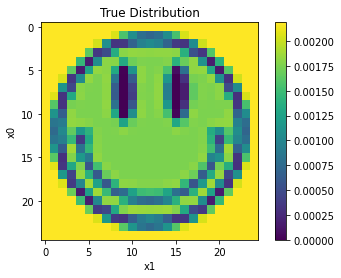

In [5]:
d = 25 # 2-D data, each dimension takes values in a finite set - {0,...,d-1}

image_url = 'https://wilson1yan.github.io/images/smiley.jpg'
fd = urlopen(image_url)
image_file = io.BytesIO(fd.read())
im = Image.open(image_file).resize((d, d)).convert('L')
im = np.array(im).astype('float32')
dist = im / im.sum() # Convert pixel intensities to probabilities

# Visualize
plot_2d_dist(dist, title='True Distribution')

# Colored image in display is not to be confused with RGB image, matplotlib
# uses a color map (to be viewed along with color bar) to display grayscale
# images. To disable this, use plt.imshow(..., cmap='gray', ...)

# A high value at a particular index (x,y) signifies high probability of
# sampling that index

**Initializing Hyperparameters and Visualizing Dataset**

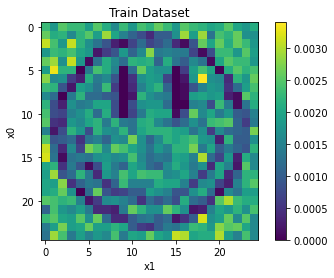

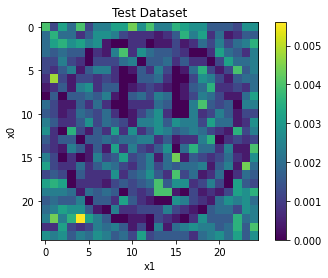

In [6]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, n_test = 10000, 2500 # Try increasing number of data points to get closer to true distribution

train_data = generate_2d_data(n_train, dist)
train_dset = NumpyDataset(train_data)
train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True)
plot_2d_dist(convert_idx_list_to_dist(train_data, d), title='Train Dataset')

test_data = generate_2d_data(n_test, dist)
test_dset = NumpyDataset(test_data)
test_loader = data.DataLoader(test_dset, batch_size=128, shuffle=True)
plot_2d_dist(convert_idx_list_to_dist(test_data, d), title='Test Dataset')

**Training Code** <br/>
We optimize the model using gradient descent and minimize negative log-likelihood

In [7]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return np.mean(train_losses[-50:])

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer)
        test_loss = eval_loss(model, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if epoch in [0, 2, 19, 49]:
            plot_2d_dist(model.get_dist(), title=f'Epoch {epoch}, Learned Distribution')

    plot_2d_dist(model.get_dist())
    plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')

*** No GPU available, training on CPU ***


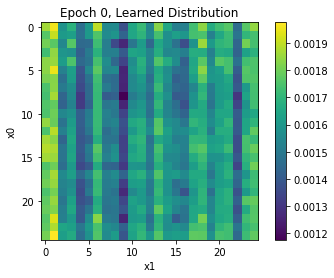

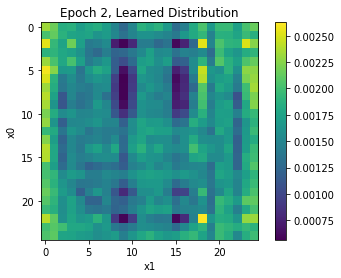

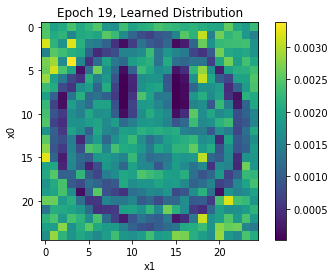

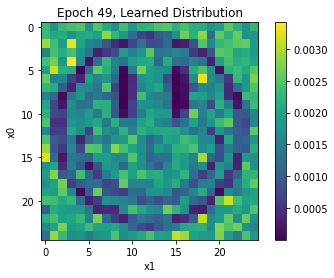

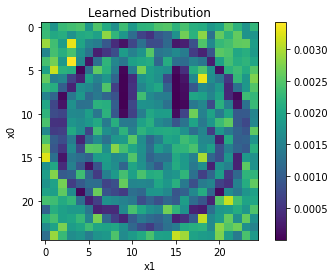

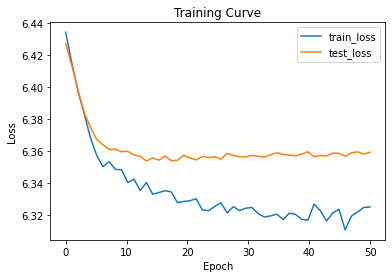

In [8]:
if torch.cuda.is_available():
    print('*** Training on GPU ***')
    device = torch.device('cuda')
else:
    print('*** No GPU available, training on CPU ***')
    device = torch.device('cpu')

class SimpleAutoregModel(nn.Module):
    # Model p(x0)p(x1|x0), p(x0) as a histogram, p(x1|x0) as an MLP
    def __init__(self):
        super().__init__()
        self.logits_x0 = nn.Parameter(torch.zeros(d), requires_grad=True) # Histogram
        self.cond_x1 = nn.Sequential( # MLP
            nn.Linear(d, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, d)
        )

    def nll(self, x):
        batch_size = x.shape[0]
        x0, x1 = x[:, 0], x[:, 1],

        # Loss for x0
        logits_x0 = self.logits_x0.unsqueeze(0).repeat(batch_size, 1)
        nll_x0 = F.cross_entropy(logits_x0, x0.long())

        # Loss for x1 | x0
        x0_onehot = to_one_hot(x0.long(), d, device) # use onehot as input, (batch_size, d)
        logits_x1 = self.cond_x1(x0_onehot)
        nll_x1 = F.cross_entropy(logits_x1, x1.long())

        return nll_x0 + nll_x1

    def get_dist(self):
        with torch.no_grad():
            x0 = torch.arange(d).to(device)
            x0 = to_one_hot(x0, d, device) # (d, d)
            prob_x0 = F.softmax(self.logits_x0, dim=0).unsqueeze(1) # (d, 1)
            prob_x1 = F.softmax(self.cond_x1(x0), dim=1) # (d, d) For each possible x0 (dim=0), what is the probability for each possible x1(dim=1)
            prob = prob_x0 * prob_x1
            return prob.cpu().numpy() # 2-D distribution


model = SimpleAutoregModel().to(device)
train_epochs(model, train_loader, test_loader, dict(epochs=50, lr=1e-3))